# Particle on a constrained line


### Import libraries

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pickle

# import local libraries
from environments.box import Box_SDI
from src.utilities.run_trial import run_trial
from src.OptimalControl.LQR import LQRSolver

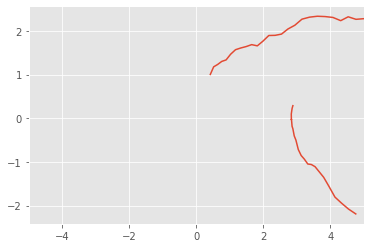

In [9]:
N = 50
threshold = .5
key = jrandom.PRNGKey(0)

env = Box_SDI()

Y = np.zeros((N, 2))
S = np.zeros((N, 2))
for it in range(N):
    u = 1
    y, rew, done, _ = env.step(u, key=key)

    Y[it] = y
    S[it] = env.state
    key, _ = jrandom.split(key)

fig, ax = plt.subplots()
idx_tmp = np.where(abs(np.diff(S[:,1])) > threshold)[0] + 1
S[idx_tmp] = np.nan
ax.plot(S[:,0], S[:,1])
ax.set_xlim([-5, 5])
plt.show()

## Soft Actor-Critic

In [2]:
from src.SoftActorCritic.main import SACAgent

# PARAMETERS
gamma = 1

memory_size = 1200
batch_size = 128
initial_random_steps = 200

control_limit = 4.
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 4
Nep = 1400
name = 'SAC_box'
noise_lvl = .3

### Train

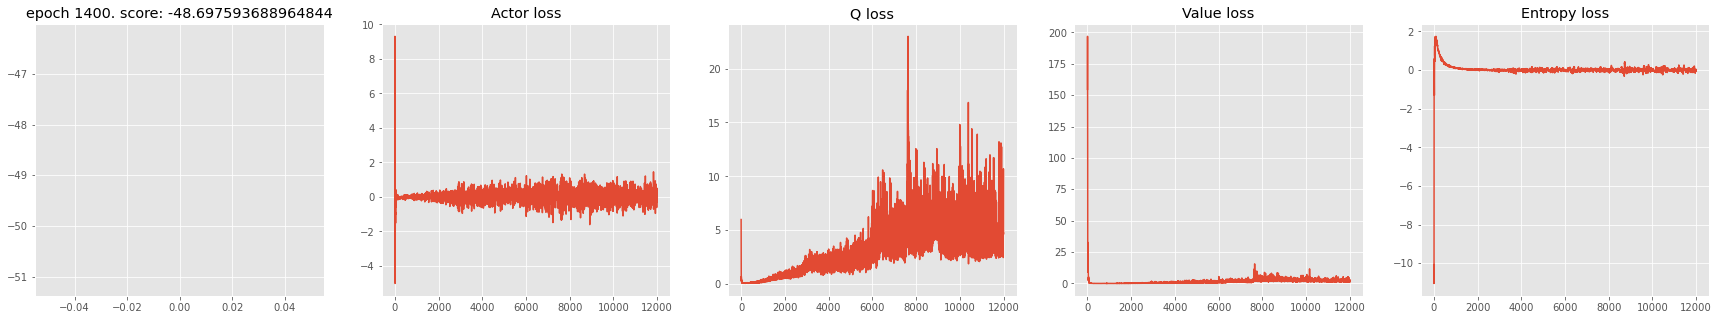

In [3]:
# RUN
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(idx)
    key = jrandom.PRNGKey(idx)

    env = Box_SDI()
    env.v = jnp.identity(2) * noise_lvl

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        lr_q=1e-2,
        memory_decay=5e-3,
        gamma=gamma
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}

In [6]:
filename = f'models/Particle_in_a_box/SAC_PO3.pickle'

"""Save params"""
# with open(filename, 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)

"""Import params"""
with open(filename, 'rb') as handle:
    PARAMS = pickle.load(handle)


'Import params'

### Results

In [7]:
env = Box_SDI()
env.v = jnp.identity(2) * 0

N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

name = list(PARAMS.keys())[0]
agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

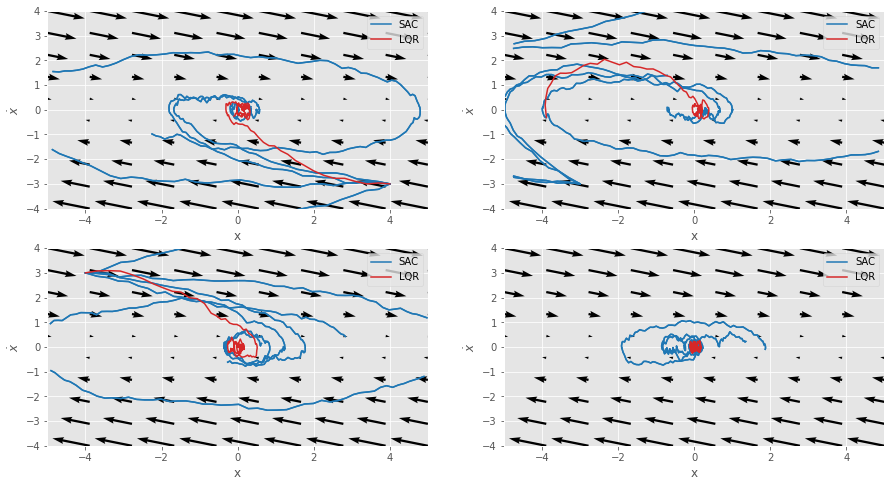

In [14]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]
threshold = .5

env.v = jnp.identity(2) * noise_lvl

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi'].predict
    for pidx in range(4):
        S, Y, U, _ = run_trial(env, controller, T=15, x0=x0[pidx])
        idx_tmp = np.where(abs(np.diff(S[:,1])) > threshold)[0] + 1
        S[idx_tmp] = np.nan
        ax[pidx].plot(S[:,0], S[:,1], c='tab:blue')
        ax[pidx].plot(S[:,0], S[:,1], c='tab:blue', label='SAC' if idx==0 else None)


lqr = LQRSolver(env.A, env.B, env.G, env.R)

for idx in range(4):
    S, Y, U, _ = run_trial(env, lqr, T=15, x0=x0[idx])
    idx_tmp = np.where(abs(np.diff(S[:,1])) > threshold)[0] + 1
    S[idx_tmp] = np.nan
    ax[idx].plot(S[:,0], S[:,1], c='tab:red', label='LQR')
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-5, 5])
    ax[idx].set_ylim([-4, 4])
    ax[idx].legend(loc=1)
plt.show()

## Recurrent Soft Actor-Critic

In [18]:
from src.SoftActorCriticRNN.main_RNN import SACAgent

# PARAMETERS
gamma = 1

memory_size = 1400
batch_size = 128
initial_random_steps = 200

hidden_size = 32
history_size = 12
control_limit = 4.
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 4
Nep = 1400
noise_lvl = .3
name = 'RSAC_box_PO'

### Train

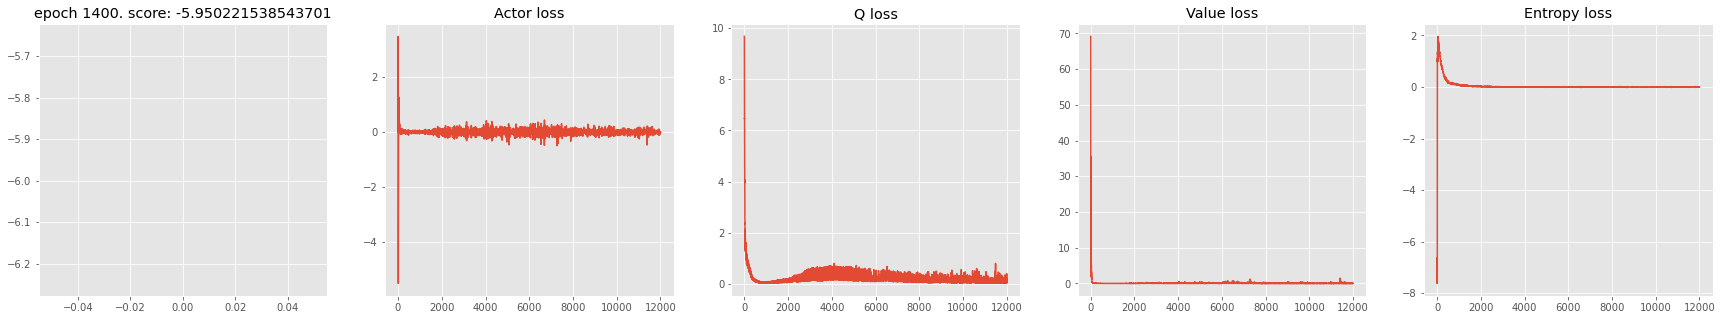

In [16]:
# RUN
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(idx+2)
    key = jrandom.PRNGKey(idx+2)

    env = Box_SDI()
    env.v = jnp.identity(2) * noise_lvl

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        lr_q=1e-3,
        memory_decay=5e-3,
        gamma=gamma,
        history_size=history_size,
        hidden_size=hidden_size
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}

In [17]:
# filename = f'models/Particle_in_a_box/RSAC_PO3.pickle'

# with open(filename, 'rb') as handle:
#     SAVED = pickle.load(handle)

# PARAMS[name] += SAVED[name]

# with open(filename, 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
filename = f'models/Particle_in_a_box/RSAC_PO3.pickle'

"""Save params"""
# with open(filename, 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)

"""Import params"""
with open(filename, 'rb') as handle:
    PARAMS = pickle.load(handle)


### Results

In [19]:
env = Box_SDI()
env.v = jnp.identity(2) * 0

N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

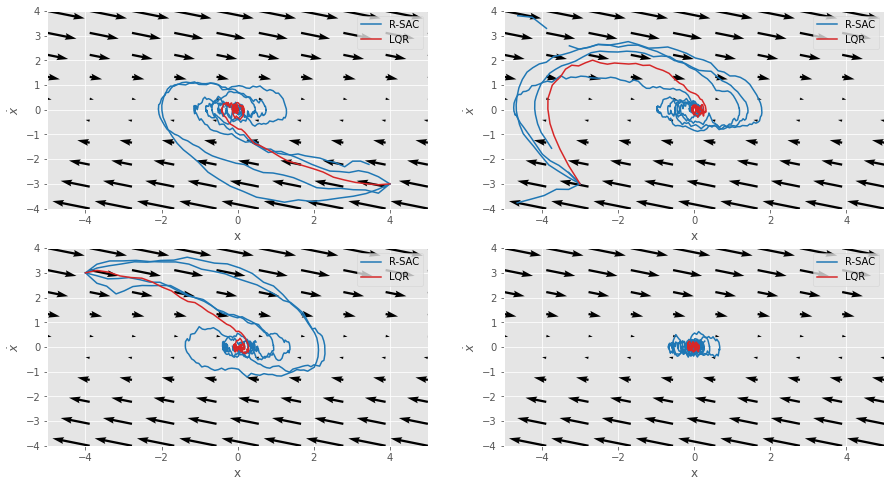

In [24]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]
threshold = .5

env.v = jnp.identity(2) * noise_lvl

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi'].predict_step
    for pidx in range(4):
        S, Y, U, _ = run_trial(env, controller, T=15, x0=x0[pidx], recurrent=True, hidden_size=hidden_size)
        idx_tmp = np.where(abs(np.diff(S[:,1])) > threshold)[0] + 1
        S[idx_tmp] = np.nan
        ax[pidx].plot(S[:,0], S[:,1], c='tab:blue', label='R-SAC' if idx==0 else None)

env.v = jnp.identity(2) * 0
lqr = LQRSolver(env.A, env.B, env.G, env.R)

for idx in range(4):
    S, Y, U, _ = run_trial(env, lqr, T=15, x0=x0[idx])
    ax[idx].plot(S[:,0], S[:,1], c='tab:red', label='LQR')
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-5, 5])
    ax[idx].set_ylim([-4, 4])
    ax[idx].legend(loc=1)
plt.show()

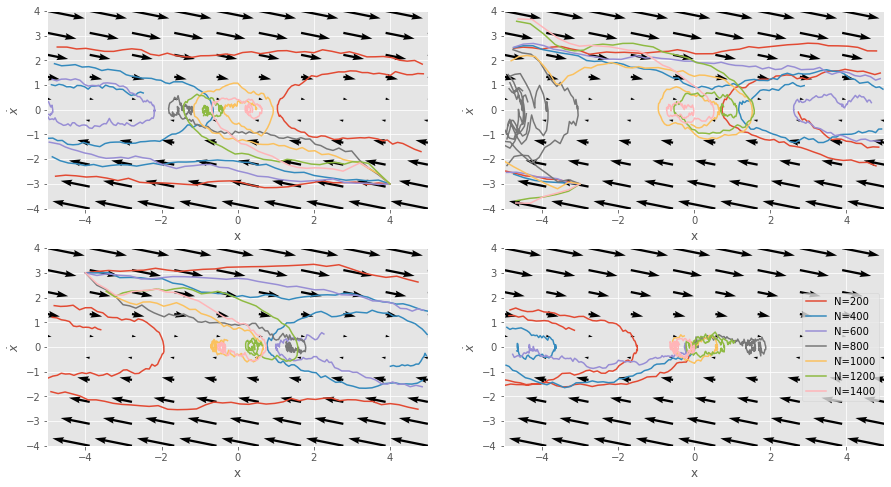

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for factor in range(1, int(Nep/200)+1):
    controller = PARAMS[name][0][f'N{factor*200}']['pi'].predict_step
    for pidx in range(4):
        S, Y, _, _ = run_trial(env, controller, T=15, x0=x0[pidx], recurrent=True, hidden_size=hidden_size)
        idx_tmp = np.where(abs(np.diff(S[:,1])) > threshold)[0] + 1
        S[idx_tmp] = np.nan
        ax[pidx].plot(S[:,0], S[:,1], label=f'N={factor*200}')

for idx in range(4):
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-5, 5])
    ax[idx].set_ylim([-4, 4])
ax[-1].legend()
plt.show()

## RSAC - Undercomplete observations

In [26]:
from src.SoftActorCriticRNN.main_RNN import SACAgent

# PARAMETERS
gamma = 1

memory_size = 1400
batch_size = 128
initial_random_steps = 200

hidden_size = 64#32
history_size = 12
control_limit = 4.
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 2
Nep = 2000 #1400
noise_lvl = 0
name = 'RSAC_box_U'

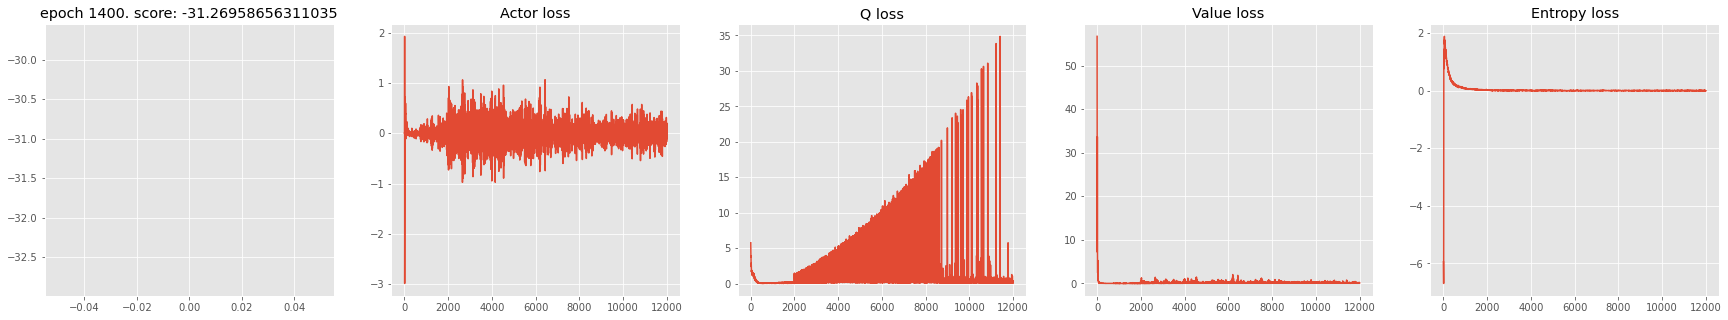

In [27]:
# RUN
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(idx)
    key = jrandom.PRNGKey(idx)

    env = Box_SDI()
    env.v = jnp.array([[1, 0], [0, 0]]) * noise_lvl
    env.C = jnp.array([[1, 0], [0, 0]])

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        lr_q=1e-3,
        memory_decay=5e-3,
        gamma=gamma,
        history_size=history_size,
        hidden_size=hidden_size
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}

In [35]:
filename = f'models/Particle_in_a_box/RSAC_Undercomplete.pickle'

"""Save params"""
# with open(filename, 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)

"""Import params"""
with open(filename, 'rb') as handle:
    PARAMS = pickle.load(handle)


'Import params'

### Results

In [28]:
env = Box_SDI()
env.v = jnp.identity(2) * 0

N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

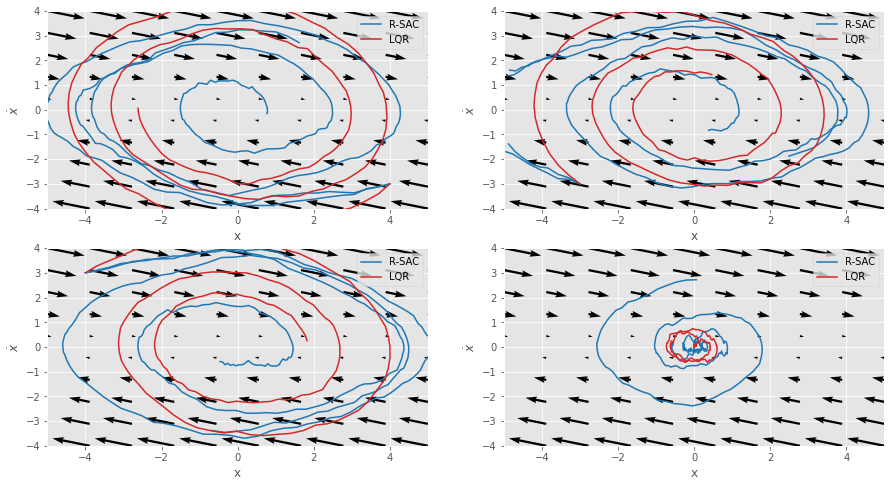

In [34]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]
threshold = .5

env.v = jnp.array([[1, 0], [0, 0]]) * noise_lvl
env.C = jnp.array([[1, 0], [0, 0]])

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi'].predict_step
    for pidx in range(4):
        S, Y, U, _ = run_trial(env, controller, T=15, x0=x0[pidx], recurrent=True, hidden_size=hidden_size)
        idx_tmp = np.where(abs(np.diff(S[:,1])) > threshold)[0] + 1
        S[idx_tmp] = np.nan
        ax[pidx].plot(S[:,0], S[:,1], c='tab:blue', label='R-SAC' if idx==0 else None)

env.v = jnp.identity(2) * 0
lqr = LQRSolver(env.A, env.B, env.G, env.R)

for idx in range(4):
    S, Y, U, _ = run_trial(env, lqr, T=15, x0=x0[idx])
    ax[idx].plot(S[:,0], S[:,1], c='tab:red', label='LQR')
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-5, 5])
    ax[idx].set_ylim([-4, 4])
    ax[idx].legend(loc=1)
plt.show()

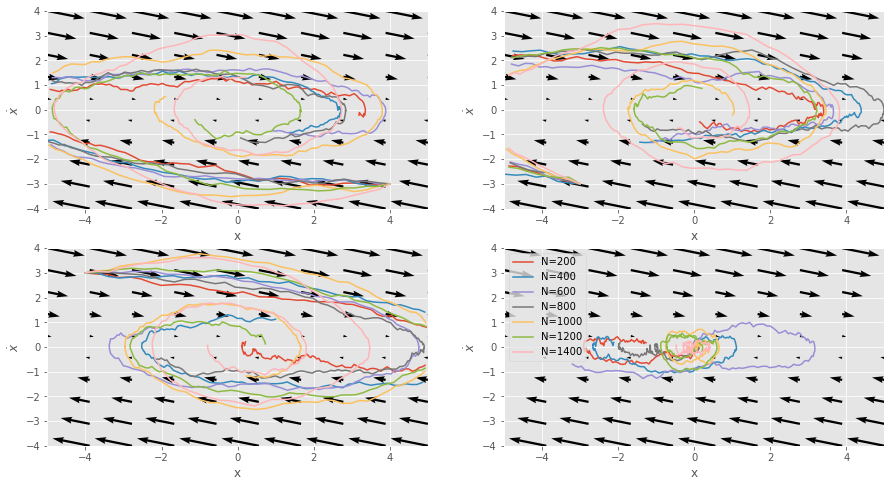

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for factor in range(1, int(Nep/200)+1):
    controller = PARAMS[name][0][f'N{factor*200}']['pi'].predict_step
    for pidx in range(4):
        S, Y, _, _ = run_trial(env, controller, T=15, x0=x0[pidx], recurrent=True, hidden_size=hidden_size)
        idx_tmp = np.where(abs(np.diff(S[:,1])) > threshold)[0] + 1
        S[idx_tmp] = np.nan
        ax[pidx].plot(S[:,0], S[:,1], label=f'N={factor*200}')

for idx in range(4):
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-5, 5])
    ax[idx].set_ylim([-4, 4])
ax[-1].legend()
plt.show()